# Experiment 03: Hyperparameter Tuning - Vocabulary Size Optimization

**Date:** December 27, 2025

**Author:** Sachin Basyal

**Experiment ID:** `optimization_max_features`

**Tracking Platform:** MLflow & DagsHub

## 1. Executive Summary
Following the results of Experiment-03, which identified **TF-IDF with Bigrams (1, 2)** as the optimal text representation, this experiment focuses on optimizing the **Vocabulary Size (`max_features`)**.

The objective is to identify the "diminishing returns" point, where adding more rare words (increasing features) no longer significantly improves accuracy but increases computational cost and the risk of overfitting.

## 2. Experiment Configuration

**Fixed Variables (Best from Exp 02):**
* **Vectorizer:** TF-IDF
* **N-Gram Range:** (1, 2) [Unigrams + Bigrams]
* **Model:** Random Forest (n=200, depth=15)

**Independent Variable (To be tested):**
* `max_features`: [1000, 2000, 3000, 4000, 5000, 8000, 10000]

In [8]:
# --- INSTALLATION & SETUP ---
!pip install mlflow dagshub --quiet

import mlflow
import dagshub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- CONFIGURATION ---
REPO_OWNER = "frivorocker"
REPO_NAME = "yt_baseline_model"

# 1. Connect Colab to DagsHub
dagshub.init(repo_name=REPO_NAME, repo_owner=REPO_OWNER, mlflow=True)

# 2. Set up the MLflow tracking server
mlflow.set_tracking_uri(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow")

# 2. Set the NEW experiment name
mlflow.set_experiment("Exp_03_Max_Features_Tuning")

Initialized MLflow to track repo "frivorocker/yt_baseline_model"

Repository frivorocker/yt_baseline_model initialized!

<Experiment: artifact_location='mlflow-artifacts:/a7f74a997c12442aaf0d45532f76ab90', creation_time=1766866648508, experiment_id='2', last_update_time=1766866648508, lifecycle_stage='active', name='Exp_03_Max_Features_Tuning', tags={}>

*Reading preprocessing data*

In [9]:
df = pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [ ]:
def run_experiment_tfidf_max_features(max_features):
    # Using (1, 2) based on Exp 03 results
    ngram_range = (1, 2)

    # 1. Vectorization
    # Note: We fit on Train and transform Test to prevent data leakage
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['clean_comment'],
        df['category'],
        test_size=0.2,
        random_state=42,
        stratify=df['category']
    )

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train = vectorizer.fit_transform(X_train_raw)
    X_test = vectorizer.transform(X_test_raw)

    # 2. MLflow Tracking
    run_name = f"TFIDF_Bigrams_Feats_{max_features}"

    with mlflow.start_run(run_name=run_name):
        # A. Log Tags & Params
        mlflow.set_tag("experiment_type", "optimization")
        mlflow.set_tag("model_type", "RandomForestClassifier")
        mlflow.set_tag("description", f"Optimizing max_features with TF-IDF Bigrams. Size={max_features}")

        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", str(ngram_range))
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Model Params
        n_estimators = 200
        max_depth = 15
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # B. Train Model
        print(f"Training with max_features={max_features}...")
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # C. Evaluate
        y_pred = model.predict(X_test)

        # Log Metrics
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log Detailed Metrics
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # D. Artifacts (Confusion Matrix)
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: Max Features {max_features}")

        # FIXED: Save to absolute path /content/
        plot_path = "/content/confusion_matrix.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.close()

        # Log Model
        mlflow.sklearn.log_model(model, name="model")

        print(f"   -> Accuracy: {accuracy:.4f}")

# --- EXECUTION ---
# Step 6: Test various max_features values
max_features_values = [1000, 2000, 3000, 4000, 5000, 8000, 10000]

print(f"Starting optimization loop for {len(max_features_values)} configurations...\n")
for mf in max_features_values:
    run_experiment_tfidf_max_features(mf)

print("\n Optimization Complete! Check DagsHub for the metrics comparison.")

Starting optimization loop for 7 configurations...

Training with max_features=1000...


2025/12/27 20:18:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6628
🏃 View run TFIDF_Bigrams_Feats_1000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/45bb3da17c3c47a0b8662f319bdc2551
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2
Training with max_features=2000...


2025/12/27 20:20:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6614
🏃 View run TFIDF_Bigrams_Feats_2000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/c8a09c6be7fb4e98a4e48c76979b16ea
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2
Training with max_features=3000...


2025/12/27 20:21:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6535
🏃 View run TFIDF_Bigrams_Feats_3000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/c9f1903200224675b10f55ec54abd997
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2
Training with max_features=4000...


2025/12/27 20:22:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6467
🏃 View run TFIDF_Bigrams_Feats_4000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/0fba5d148b854ac8ba7ea2fe9fe98334
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2
Training with max_features=5000...


2025/12/27 20:23:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6568
🏃 View run TFIDF_Bigrams_Feats_5000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/ae329726c8514893ba8935564b982d63
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2
Training with max_features=8000...


2025/12/27 20:24:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6446
🏃 View run TFIDF_Bigrams_Feats_8000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/039addc857de477d863fc6e4a87ac9b1
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2
Training with max_features=10000...


2025/12/27 20:25:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   -> Accuracy: 0.6412
🏃 View run TFIDF_Bigrams_Feats_10000 at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2/runs/f628303f62bc49eeb0eb25dcec94b533
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/2

 Optimization Complete! Check DagsHub for the metrics comparison.


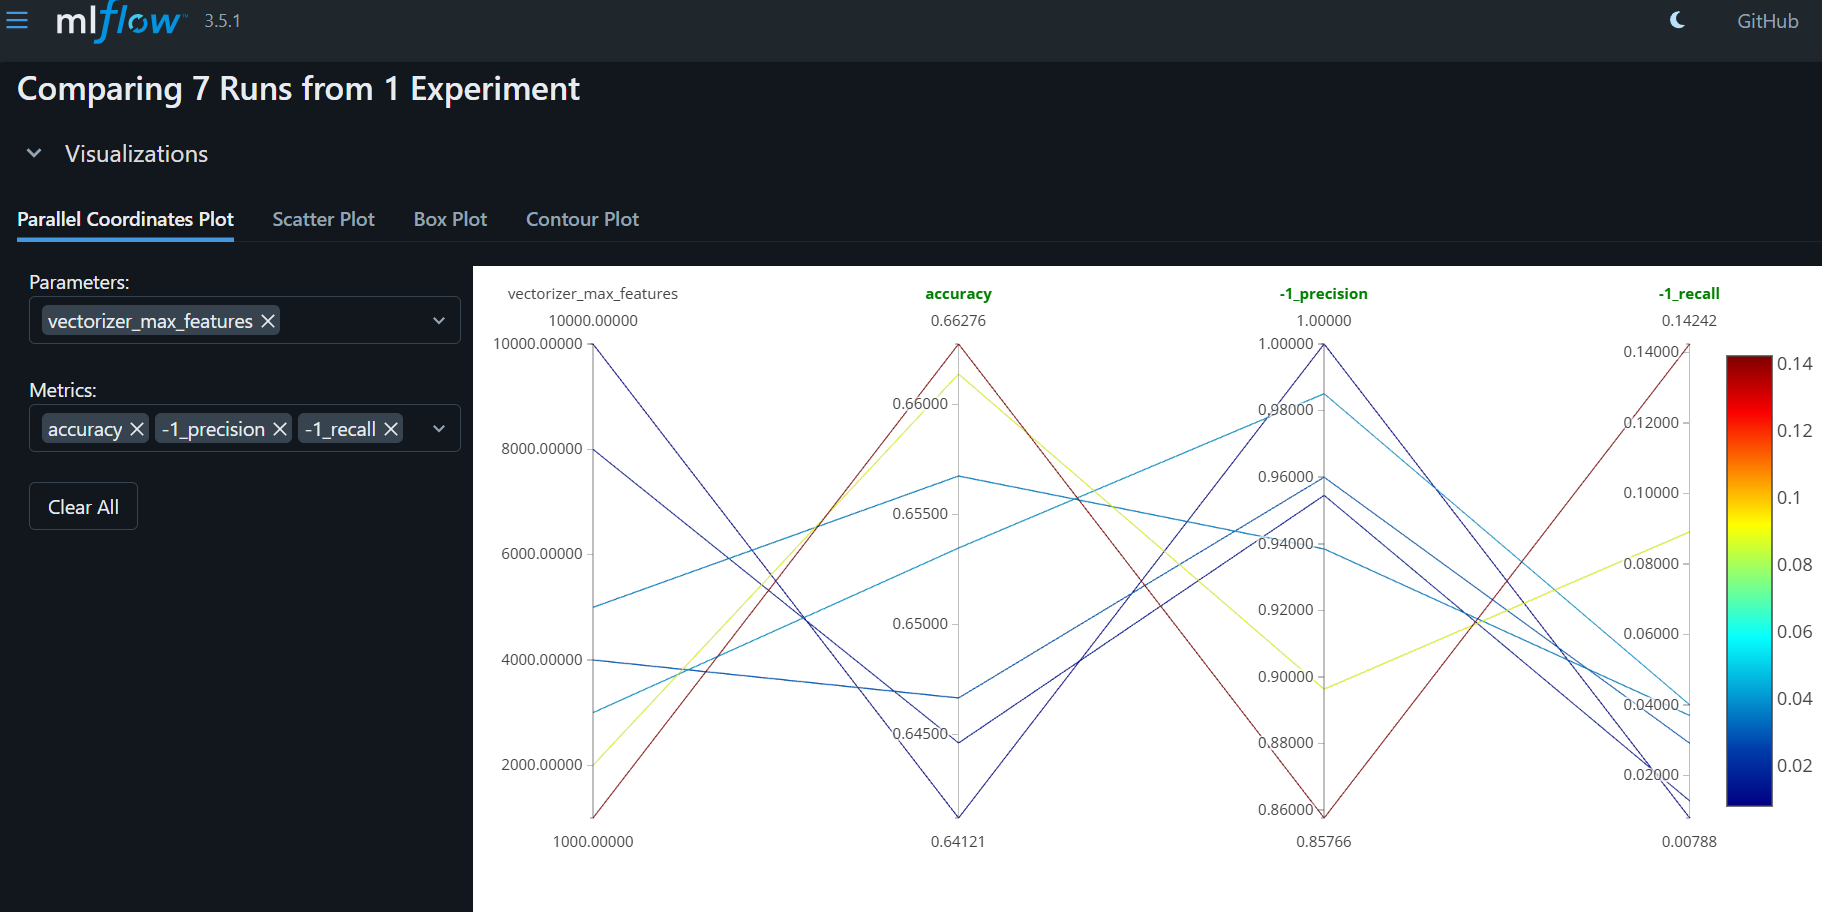

## 3. Results & Analysis

Upon completing the optimization loop, we analyzed the **Parallel Coordinates Plot** in MLflow to determine the impact of vocabulary size (`vectorizer_max_features`) on model performance (`accuracy` and `recall_negative`).

**Key Observations:**
1.  **Inverse Relationship:** Model accuracy demonstrated an inverse relationship with feature size. Performance peaked at **1,000 features** and showed a gradual decline as the vocabulary size increased to 10,000.
2.  **Performance Ceiling (~66%):** Despite optimizing the feature space, the overall accuracy remains capped at approximately **66%**.
3.  **Root Cause:** This performance ceiling indicates that feature engineering alone cannot overcome the underlying **class imbalance** in the dataset. The model is likely biased towards the majority class, limiting its ability to generalize effectively.

## 4. Conclusion and Next Steps

### Conclusion
We select **1,000 features** as the optimal configuration for the TF-IDF vectorizer. It provides the highest relative accuracy while maintaining the lowest computational footprint (least memory usage and fastest training time).

### Next Steps (Addressing the 66% Ceiling)
To break through the current performance plateau, we must explicitly handle the data imbalance:
1.  **Resampling Techniques:** Implement **SMOTE** (Synthetic Minority Over-sampling Technique) to synthetically boost the minority class.
2.  **Class Weights:** Adjust the Random Forest `class_weight='balanced'` parameter to heavily penalize misclassifications of the minority class.
3.  **Advanced Models:** Benchmark **XGBoost** or **Gradient Boosting**, which often handle imbalanced data more robustly than standard Random Forests.